# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

### This Project Framework was provided by Udacity ML Nanodegree program. They helped set-up the skelton for me to build a dog breed classification.

In [ ]:
# Download dog dataset only have to run once
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages

In [ ]:
# Download human dataset only have to run once
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvzf lfw.tgz

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [2]:
!pip install opencv-python

    100% |████████████████████████████████| 28.2MB 1.8MB/s eta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Number of faces detected: 2


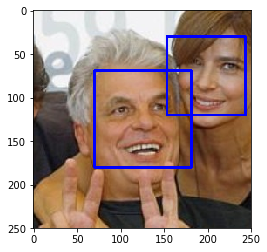

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def face_detector_score(image_path_arr):
    cnt_faces_true = sum([1 if face_detector(i) else 0 for i in image_path_arr])
    cnt_faces = len(image_path_arr)
    
    return (1.0*cnt_faces_true) / cnt_faces
    
print("Percent of Human Faces detected: {:.2%} from human files".format(face_detector_score(human_files_short)))
print("Percent of Human Faces detected: {:.2%} from dog files".format(face_detector_score(dog_files_short)))
    


Percent of Human Faces detected: 99.00% from human files
Percent of Human Faces detected: 10.00% from dog files


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 51.1MB/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [14]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    min_img_size = 224  # 

    img = Image.open(img_path).convert('RGB')
    transform_pipeline = transforms.Compose([transforms.Resize(size = (min_img_size,min_img_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]
                                           )
    img = transform_pipeline(img)   
    img = img.unsqueeze(0)
    pred = VGG16(img)
    prob = torch.exp(pred)
    top_probability, top_class = prob.topk(1, dim=1)
    return top_class  # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    vgg_score = VGG16_predict(img_path)
    if vgg_score >= 151 and vgg_score <= 268:
        is_dog = True
    else:
        is_dog = False
    
    return is_dog # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [16]:
dog_files_short[0]

'dogImages/train/122.Pointer/Pointer_07830.jpg'

In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_detector_score(image_path_arr):
    cnt_dogs_true = sum([1 if dog_detector(i) else 0 for i in image_path_arr])
    cnt_dogs = len(image_path_arr)
    
    return (1.0*cnt_dogs_true) / cnt_dogs
    
    

In [18]:
print("Percent of Dogs detected: {:.2%} from human files".format(dog_detector_score(human_files_short)))


Percent of Dogs detected: 1.00% from human files


In [19]:
print("Percent of Dogs detected: {:.2%} from dog files".format(dog_detector_score(dog_files_short)))


Percent of Dogs detected: 100.00% from dog files


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [20]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [38]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# transforms
traindata_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                        ])

validdata_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                         ])
                                         #transforms.CenterCrop(224),

testdata_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

                                         
                                         

In [39]:
# 
train = datasets.ImageFolder(root="dogImages/train/", transform = traindata_transform)

val = datasets.ImageFolder(root="dogImages/valid/", transform = validdata_transform)

test = datasets.ImageFolder(root="dogImages/test/", transform = testdata_transform)

In [40]:
# batch
train_batches = torch.utils.data.DataLoader(train,
                                            batch_size=20, 
                                            shuffle=True,
                                            num_workers=0)
val_batches = torch.utils.data.DataLoader(val,
                                          batch_size=20, 
                                          shuffle=False,
                                          num_workers=0)
test_batches = torch.utils.data.DataLoader(test,
                                           batch_size=20,
                                           shuffle=False,
                                           num_workers=0)

loaders_scratch = dict(train=train_batches,
                       valid=val_batches,
                       test=test_batches)



**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I chose to resize the photo to 224 because that's the standard practice that I saw in other examples. And I also saw that was the size resnet needed (for transfer learning section).

For the training data,I used RandomResizedCrop(224) and RandomHorizontalFlip() as that both resized and augmented the data.  I didn't do any other augmentations such as rotations (because I passed the test requirements). 

For validation, I don't quite understand why I resize the image to 256 and then centercrop to 224. That was how validation was setup in the pytorch training doc:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
Didn't find any good resources that explained the reasoning other than one person seeing their accuracy drop if they changed validation to just resizing to 224.

For test data, I resized the image to 224.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        #self.fc1 = nn.Linear(7*7*400, 500)
        self.fc1 = nn.Linear(7*7*256, 500)
        self.fc2 = nn.Linear(500, 133) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        
              
        #### VERSION 1
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.pool(x)
        #print(x.shape)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool(x)
        #print(x.shape)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.pool(x)
        #print(x.shape)
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.pool(x)
        #print(x.shape)       

        #print(x.shape)
        # flatten
        x = x.view(-1, 7*7*256)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x


       
        


#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I useed these resources to learn understand what a CNN is and how to deploy one: 
- https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/,
- https://medium.com/@vivekvscool/image-classification-cnn-with-pytorch-5b2cb9ef9476,
- https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/,
- https://towardsdatascience.com/convolutional-neural-network-for-image-classification-with-implementation-on-python-using-pytorch-7b88342c9ca9,https://discuss.pytorch.org/t/how-do-you-pick-the-number-of-in-channels-and-out-channels-in-conv2d-layers/12787

I also found this github that helped me get my CNN to work:
- https://github.com/teddylee777/dog-breed-classifier/blob/master/dog_app.ipynb

My original design was to have 5 convolution layers with batch normalization after each step. The reason for the five layers was because that's the design for the Alexnet transfer model (in github). I also chose the first output layer to be 64. What I found was that my model trained really slowly so I modified my first output layer to 32 (I read that typically the first output layer should be over 50). When I reduced my model to four layers, I tried two versions. The first version had four layers but the first layer had a stride = 1 and the other version had stride = 2. I got better training and testing performance when using stride = 2. I read that the first layer in resnet model uses stride = 2 and that article talks about how the performance can improve with stride = 2 https://stats.stackexchange.com/questions/387482/pooling-vs-stride-for-downsampling

Between each layer I normalized the data with BatchNorm2d. 

I also have 0.3 dropout to not overfit the data. And 2 fully connect layers with the last layer predicting dog breeds

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [25]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
#optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.07)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [41]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                            valid_loss))
            valid_loss_min = valid_loss            
    # return trained model
    return model




In [ ]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.874516 	Validation Loss: 4.687090
Validation loss decreased (inf --> 4.687090).  Saving model ...
Epoch: 2 	Training Loss: 4.757493 	Validation Loss: 4.578887
Validation loss decreased (4.687090 --> 4.578887).  Saving model ...
Epoch: 3 	Training Loss: 4.696357 	Validation Loss: 4.499798
Validation loss decreased (4.578887 --> 4.499798).  Saving model ...
Epoch: 4 	Training Loss: 4.644254 	Validation Loss: 4.664841
Epoch: 5 	Training Loss: 4.626554 	Validation Loss: 4.442275
Validation loss decreased (4.499798 --> 4.442275).  Saving model ...
Epoch: 6 	Training Loss: 4.578248 	Validation Loss: 4.419366
Validation loss decreased (4.442275 --> 4.419366).  Saving model ...
Epoch: 7 	Training Loss: 4.560333 	Validation Loss: 4.271135
Validation loss decreased (4.419366 --> 4.271135).  Saving model ...
Epoch: 8 	Training Loss: 4.527987 	Validation Loss: 4.277452
Epoch: 9 	Training Loss: 4.485596 	Validation Loss: 4.313925
Epoch: 10 	Training Loss: 4.459472 	Valida

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [42]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [30]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.874846


Test Accuracy: 11% (94/836)


^ I only ran 20 epoch but when I ran more epochs, I got to 15% test accuracy.

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [43]:
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [32]:
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/#transferlearningtheory

In [44]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.resnet50(pretrained=True)
#model_transfer = models.inception_v3(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.3MB/s]


In [46]:
for parameter in model_transfer.parameters():
    parameter.requires_grad = False

In [47]:
model_transfer.fc = nn.Linear(in_features=2048,
                              out_features=133,
                              bias=True)

In [48]:
parameters_fc = model_transfer.fc.parameters()

In [49]:
for parameter in parameters_fc:
    parameter.requires_grad = True

In [50]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

In [71]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


I choose the resnet model. I read some articles that showed that of the three models: 
    resnet, vgg, and inception
Resnet had the best performance.

The only modification I made to the model was to change the final connect layers output to 133 for the 133 dog breeds that we're trying to predict.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [51]:
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
#optimizer_scratch = optim.Adam(model_transfer.parameters(), lr=0.07)
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [40]:
n_epochs = 10

In [41]:
# train the model
model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.077494 	Validation Loss: 2.818111
Validation loss decreased (inf --> 2.818111).  Saving model ...
Epoch: 2 	Training Loss: 2.791906 	Validation Loss: 1.779071
Validation loss decreased (2.818111 --> 1.779071).  Saving model ...
Epoch: 3 	Training Loss: 2.126387 	Validation Loss: 1.286803
Validation loss decreased (1.779071 --> 1.286803).  Saving model ...
Epoch: 4 	Training Loss: 1.755540 	Validation Loss: 0.984303
Validation loss decreased (1.286803 --> 0.984303).  Saving model ...
Epoch: 5 	Training Loss: 1.542576 	Validation Loss: 0.870995
Validation loss decreased (0.984303 --> 0.870995).  Saving model ...
Epoch: 6 	Training Loss: 1.391209 	Validation Loss: 0.784311
Validation loss decreased (0.870995 --> 0.784311).  Saving model ...
Epoch: 7 	Training Loss: 1.284740 	Validation Loss: 0.708664
Validation loss decreased (0.784311 --> 0.708664).  Saving model ...
Epoch: 8 	Training Loss: 1.229309 	Validation Loss: 0.643759
Validation loss decreased (0.70866

<All keys matched successfully>

In [52]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

# (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [53]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.645749


Test Accuracy: 83% (702/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [54]:
[item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]


['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

In [55]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path, model, class_names):
    # load the image and return the predicted breed
    # load the image
    min_img_size = 224  # The min size, as noted in the PyTorch pretrained models doc, is 224 px.

    img = Image.open(img_path).convert('RGB')
    transform_pipeline = transforms.Compose([transforms.Resize(size = (min_img_size, min_img_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])]
                                           )
    img = transform_pipeline(img)   
    img = img.unsqueeze(0)
    # evaluate image
    model = model.cpu()
    model.eval()
    i = torch.argmax(model(img))
    return class_names[i]

In [56]:
predict_breed_transfer('./images/sample_human_output.png', model_transfer, class_names)

'Brussels griffon'

In [57]:
predict_breed_transfer('./images/Labrador_retriever_06449.jpg', model_transfer, class_names)

'Flat-coated retriever'

In [58]:
predict_breed_transfer('./images/Labrador_retriever_06457.jpg', model_transfer, class_names)

'Labrador retriever'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [59]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    

    
    if dog_detector(img_path) is True:
        pred = predict_breed_transfer(img_path, model_transfer, class_names)
        print("Dog Detected!")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        print("You look like a ...\n {0}".format(pred))
    elif face_detector(img_path) > 0:
        pred = predict_breed_transfer(img_path, model_transfer, class_names)
        print("Human Detected!")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        print("You look like a ...\n {0}".format(pred))
    else:
        print("Nothing Detected!")
        img = Image.open(img_path)
        print("Tell us if we made a mistake and your picture is a dog or human")     


Human Detected!


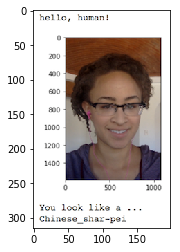

You look like a ...
 Brussels griffon
Dog Detected!


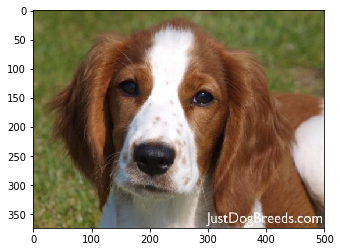

You look like a ...
 Welsh springer spaniel
Dog Detected!


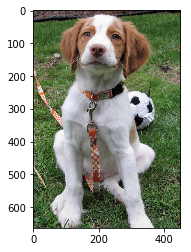

You look like a ...
 Brittany
Dog Detected!


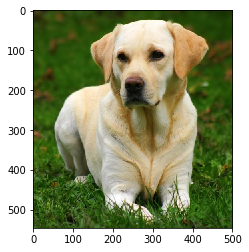

You look like a ...
 Labrador retriever
Dog Detected!


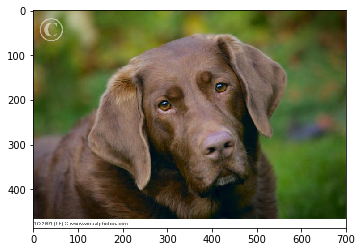

You look like a ...
 Labrador retriever
Dog Detected!


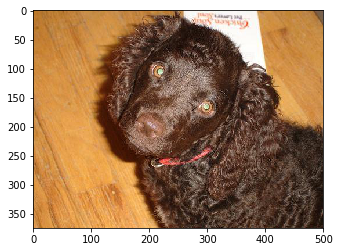

You look like a ...
 Curly-coated retriever
Dog Detected!


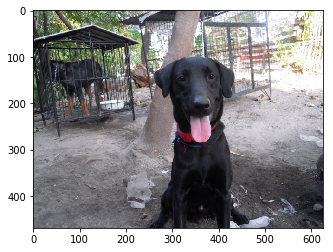

You look like a ...
 Flat-coated retriever
Nothing Detected!
Tell us if we made a mistake and your picture is a dog or human
Dog Detected!


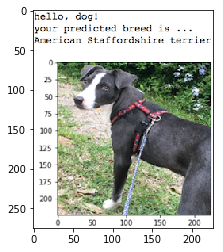

You look like a ...
 Greyhound
Dog Detected!


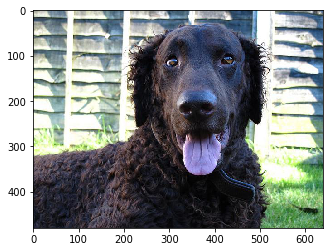

You look like a ...
 Curly-coated retriever


In [60]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output was as I expected. It detected human correctly (and the dog breed guesses were funny).

For the dogs, I gave a couple of hard choices,
- 1: A corgi but looking at the photo w/out context, I couldn't identify that is a corgi
- 2: A puppy photo (which the breed was correct)
- 3: My family dog (a toy poodle with a little bit of unknown mix) so not surprising that was hard to predict

3 ways to improve the algorithm are:
- 1. Increase training time by adding more epochs. I only did 10 epochs just because of the time it took to run on my computer but the loss function was still decreasing.
- 2. More dog images that are classified. I didn't go through all the photos but adding more varied photos of dogs could help such as a corgi drying himself or poodle running.
- 3: Image augmentations.
- 4: Hyperparameter tuning. I didn't try different learning rates, optimizers, batch size, etc.so those could improve performance. 

In [68]:

my_human_files = ['./test_pics/humans/human1.jpg', './test_pics/humans/human2.jpg', './test_pics/humans/human3.jpg', './test_pics/humans/human4.jpg' ]
my_dog_files = ['./test_pics/dogs/dog1.jpg', './test_pics/dogs/dog2.jpg', './test_pics/dogs/dog3.png']


Human Detected!


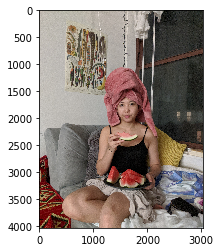

You look like a ...
 Cocker spaniel
Human Detected!


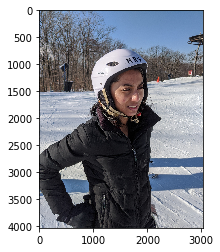

You look like a ...
 Alaskan malamute
Nothing Detected!
Tell us if we made a mistake and your picture is a dog or human
Human Detected!


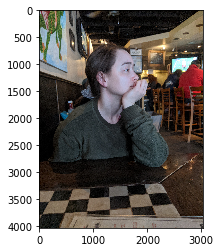

You look like a ...
 Norwegian buhund
Dog Detected!


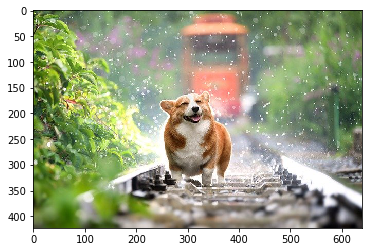

You look like a ...
 Norwegian lundehund
Human Detected!


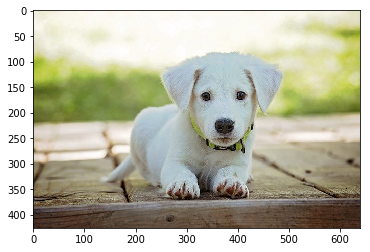

You look like a ...
 Labrador retriever
Dog Detected!


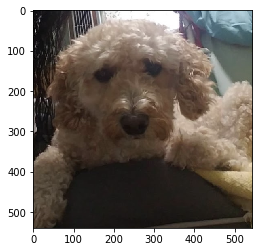

You look like a ...
 Bichon frise


In [70]:
for file in np.hstack((my_human_files, my_dog_files)):
    run_app(file)

Human Detected!


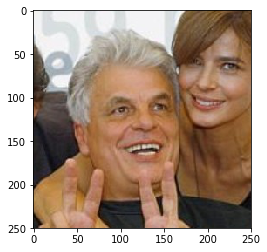

You look like a ...
 Dogue de bordeaux
Human Detected!


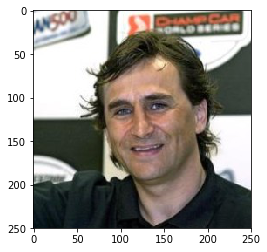

You look like a ...
 Dachshund
Nothing Detected!
Tell us if we made a mistake and your picture is a dog or human
Human Detected!


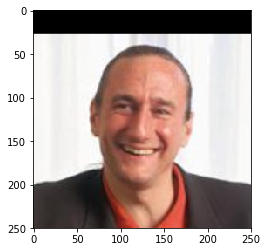

You look like a ...
 Dachshund
Dog Detected!


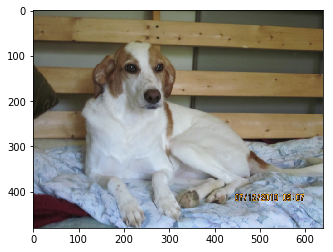

You look like a ...
 American foxhound
Dog Detected!


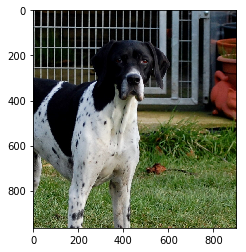

You look like a ...
 Pointer
Dog Detected!


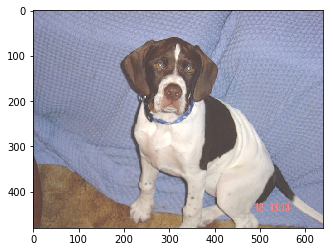

You look like a ...
 Pointer


In [61]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:4], dog_files[:3])):
    run_app(file)